In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-21 09:10:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-21 09:10:01 (85.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
train_dir="/content/drive/MyDrive/text_non_text_classifier/data/train"
test_dir="/content/drive/MyDrive/text_non_text_classifier/data/test"

In [ ]:
import tensorflow as tf
IMG_SIZE=(224,224)
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              rotation_range=40,
                                                              horizontal_flip=True,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2,
                                                              shear_range=0.2,
                                                              zoom_range=0.2,
                                                              fill_mode="nearest")

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  subset="training",
                                                  shuffle=True,
                                                  seed=42,
                                                  color_mode="rgb",
                                                  class_mode="categorical",
                                                  target_size=IMG_SIZE,
                                                  batch_size=64)

Found 133 images belonging to 2 classes.


In [ ]:
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_directory(test_dir,
                                                shuffle=True,
                                                seed=42,
                                                color_mode="rgb",
                                                class_mode="categorical",
                                                target_size=IMG_SIZE,
                                                batch_size=64)

Found 117 images belonging to 2 classes.


In [ ]:
import tensorflow_hub as hub
IMG_SIZE=(224,224)
feature_vectorizer2=hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
                                  input_shape=IMG_SIZE+(3,))

In [ ]:
inputs=tf.keras.layers.Input(shape=(224,224,3))
x=feature_vectorizer2(inputs)
x=tf.keras.layers.Flatten()(x)
# x=tf.keras.layers.Dense(256,activation="relu")(x)
x=tf.keras.layers.Dense(512,activation="relu")(x)
# x=tf.keras.layers.MaxPool2D()(x)
x=tf.keras.layers.Dense(256,bias_initializer='ones',activation="relu")(x)
# x=tf.keras.layers.Conv2D(100,3,activation="relu")(x)
x=tf.keras.layers.Dense(128,activation="relu")(x)
x=tf.keras.layers.Dense(64,activation="relu")(x)
# x=tf.keras.layers.Dense(32,activation="relu")(x)
x=tf.keras.layers.Dropout(0.2)(x) 
outputs=tf.keras.layers.Dense(train_generator.num_classes,activation="softmax")(x)
model=tf.keras.Model(inputs,outputs)

model.compile(loss="categorical_crossentropy",
metrics=["accuracy"],
optimizer="adam")

history=model.fit(train_generator,
                      epochs=10,
                      steps_per_epoch=train_generator.samples//train_generator.batch_size,
                      validation_data=test_generator,
                      validation_steps=test_generator.samples//test_generator.batch_size)
                      # callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=7, restore_best_weights=True),
                      # tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

Epoch 1/10
2/2 [==============================] - 143s 81s/step - loss: 0.9501 - accuracy: 0.5217 - val_loss: 0.0888 - val_accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 23s 22s/step - loss: 0.0537 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 25s 18s/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 23s 16s/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 25s 18s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.9173e-04 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 23s 16s/step - loss: 7.0003e-04 - accuracy: 1.0000 - val_loss: 9.2114e-05 - val_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 24s 18s/step - loss: 2.8108e-04 - accuracy: 1.0000 - val_loss: 3.6789e-05 - val_accuracy: 1.0000
Epoch 

In [ ]:
model.save("text_non_text_model2.h5")

## Loading the model

In [ ]:
loaded_model=tf.keras.models.load_model("text_non_text_model2.h5",custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
# Create a function to import an image and resize it tbe able to be used with our model
import tensorflow as tf
def load_and_prep_image(filename,img_shape=224):
  """
  Reads an image from the filename, turns it into a tensor and reshape it,
  to (img_shape,img_shape,color channels)
  """
  # Read in the image 
  img=tf.io.read_file(filename)

  # brightness(img)
  # Decode the read file into a tensor
  img=tf.image.decode_image(img)
  # Resize the image
  img=tf.image.resize(img,size=[img_shape,img_shape])
  # Resacle the image and resacale all the values between 0 and 1 
  img=img/255.

  return img

In [ ]:
class_names=["non_text_image","text_image"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
def pred_and_plot(model,filename,class_names=class_names):
  # Import the target image and preprocess it.
  
  img=load_and_prep_image(filename)
  img = tf.convert_to_tensor(img[:,:,:3])
  # brightness(img)
  # Make predictions 
  # Brightness Calculator

  pred=model.predict(tf.expand_dims(img,axis=0))

  # Get the predicted class
  pred_class=class_names[int(np.argmax((tf.round(pred))))]

  # print(pred_class)
  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"prediction: {pred_class}")
  plt.axis(False);

  if(pred_class=="text_image"):
    flag=1
  else:
    flag=0
  
  if(flag==1):
    return True
  else:
    return False

False

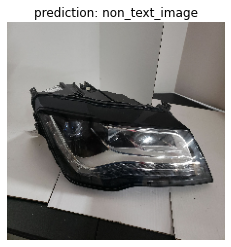

In [ ]:
pred_and_plot(loaded_model,"/content/drive/MyDrive/text_non_text_classifier/data/test/non_text_image/1-12-22 (1938).jpg")

True

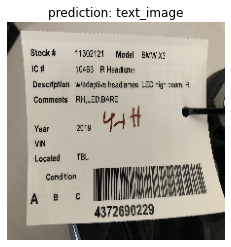

In [ ]:
pred_and_plot(loaded_model,"/content/drive/MyDrive/text_non_text_classifier/data/test/text_image/1-12-22 (2577).JPG")

In [ ]:
model.save("Model")

INFO:tensorflow:Assets written to: Model/assets


INFO:tensorflow:Assets written to: Model/assets
